# Predicting Love at First Sight
**Objective**  
Develop a classification model to identify which rounds of speed dating end in a match (both the participant and the partner both decide "yes" on their scorecard)

**Data**   
This [dataset](https://www.kaggle.com/annavictoria/speed-dating-experiment) was obtained from Kaggle and was obtained by Columbia Business School professors Ray Fisman and Sheena Iyengar.

In [2]:
from sqlalchemy import create_engine

import pickle

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import imblearn.over_sampling

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler

**Load the data in from AWS**

In [29]:
def get_dataframes_from_aws():
    '''
    This script connects to PostgreSQL from an AWS EC2 instanace and returns 2
    datafames that have null values removed. You will need to add change and add your
    specific EC2 IP address to the script in the cnx variable below.
    '''
    cnx = create_engine('postgresql://ubuntu@YOUR_IP_ADDRESS:5432/loves')

    date_data = pd.read_sql_query('''select match, attr, sinc, intel, fun, amb, shar, like_1, prob,
                                    met, attr_o, sinc_o, intel_o, fun_o, amb_o, shar_o, like_o, prob_o, met_o
                                    from speeddating6
                                    where shar_o is not null
                                    and shar is not null
                                    and amb_o is not null
                                    and amb is not null
                                    and met_o is not null
                                    and met is not null
                                    and fun is not null
                                    and prob is not null
                                    and prob_o is not null
                                    and intel is not null
                                    and fun_o is not null
                                    and attr is not null
                                    and intel_o is not null
                                    and sinc is not null
                                    and attr_o is not null
                                    and sinc_o is not null
                                    and like_o is not null
                                    and like_1 is not null ''',
                                    cnx)

    participant_data = pd.read_sql_query('''select avg(date_3) as date_after, iid as participant,
                                                avg(date) as date_freq, avg(go_out) as go_out_freq,
                                                avg(imprace) as race_importance, avg(imprelig) as religious_importance,
                                                avg(sports) as sports, avg(tvsports) as tvsports, avg(exercise) as exercise,
                                                avg(dining) as dining, avg(museums) as museums, avg(art) as art,
                                                avg(hiking) as hiking, avg(gaming) as gaming, avg(clubbing) as clubbing,
                                                avg(tv) as tv, avg(theater) as theater, avg(concerts) as concerts,
                                                avg(music) as music, avg(yoga) as yoga, avg(attr3_1) as self_attractive,
                                                avg(sinc3_1) as self_sincere, avg(intel3_1) as self_intelligent,
                                                avg(fun3_1) as self_fun, avg(reading) as reading 
                                                from speeddating6 
                                                where date_3 is not null
                                                and exercise is not null
                                                and attr3_1 is not null
                                                group by iid
                                                order by avg(match) desc;''',
                                                cnx)

    return date_data, participant_data


In [30]:
date_data, participant_data = get_dataframes_from_aws()

**Clean the dataframes**

In [31]:
def date_data_feature_engineering(date_data):
    '''
    Returns a dataframe with additional engineered features and drops features that
    do not have an impact on the performance of the final model of predicting a match in
    a round of speed dating.
    '''

    # Feature engineering
    date_data['diff_attr'] = date_data['attr'] - date_data['attr_o']
    date_data['diff_sinc'] = date_data['sinc'] - date_data['sinc_o']
    date_data['diff_intel'] = date_data['intel'] - date_data['intel_o']
    date_data['diff_fun'] = date_data['fun'] - date_data['fun_o']
    date_data['diff_amb'] = date_data['amb'] - date_data['amb_o']
    date_data['diff_shar'] = date_data['shar'] - date_data['shar_o']
    date_data['diff_like'] = date_data['like_1'] - date_data['like_o']
    date_data['diff_prob'] = date_data['prob'] - date_data['prob_o']
    date_data['diff_met'] = date_data['met'] - date_data['met_o']

    date_data['abs_val_sum_differences'] = (date_data['diff_attr'].abs() + date_data['diff_sinc'].abs() + date_data['diff_intel'].abs()
                                        + date_data['diff_fun'].abs() + date_data['diff_amb'].abs() + date_data['diff_shar'].abs()
                                        + date_data['diff_like'].abs() + date_data['diff_prob'].abs() + date_data['diff_met'].abs())

    date_data['attr_times_like'] = date_data['attr'] * date_data['like_1']
    date_data['partner_attr_times_like'] = date_data['attr_o'] * date_data['like_o']

    # Drop unnecessary features
    date_data.drop(columns=['attr_o', 'sinc', 'sinc_o', 'intel', 'intel_o', 'fun_o', 'amb', 'amb_o', 'shar_o', 'like_o', 'prob', 'prob_o', 'met', 'met_o'], inplace=True)

    return date_data

In [35]:
def participant_data_feature_engineering(participant_data):
    '''
    Returns a dataframe with additional engineered features and drops features that
    do not have an impact on the performance of the final model of predicting a date after
    a speed dating event.
    '''

    # Feature engineering
    participant_data['race_squared'] = participant_data['race_importance'] **2
    participant_data['confidence'] = participant_data['self_intelligent'] + participant_data['self_fun'] + participant_data['self_attractive']
    participant_data['sociableness'] = participant_data['date_freq'] + participant_data['go_out_freq']
    participant_data['tv_oriented_activities'] = (participant_data['tv'] + participant_data['tvsports'] + participant_data['gaming'])
    participant_data['culture_activities'] = (participant_data['museums'] + participant_data['art'] + participant_data['reading'] + participant_data['theater'] + participant_data['music'])
    participant_data['social_outings'] = (participant_data['clubbing'] + participant_data['dining'] + participant_data['concerts'])
    participant_data['active_activities'] = (participant_data['sports'] + participant_data['exercise'] + participant_data['hiking'] + participant_data['yoga'])

    # Drop unnecessary features
    participant_data.drop(columns=['date_freq', 'go_out_freq', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'tv', 'theater', 'concerts', 'music', 'yoga', 'self_attractive', 'self_fun'], inplace=True)

    return participant_data

In [33]:
# Clean the date data
date_data = date_data_feature_engineering(date_data)

In [36]:
# Clean the participant data
participant_data = participant_data_feature_engineering(participant_data)

In [37]:
# # Pickle dataframes for future use
# with open('date_data.pkl', 'wb') as f:
#     pickle.dump(date_data, f)

# with open('participant_data.pkl', 'wb') as f:
#     pickle.dump(participant_data, f)

## **Date Data: Predicting a match in a round of speed dating**

In [3]:
# Load in cleaned dataframes 
date_data = pickle.load(open("date_data.pkl","rb"))
participant_data = pickle.load(open("participant_data.pkl","rb"))

In [4]:
date_data.head()

match  attr  fun  shar  like_1  diff_attr  diff_sinc  diff_intel  diff_fun  \
0      0   6.0  7.0   5.0     7.0        0.0        1.0        -1.0      -1.0   
1      0   7.0  8.0   6.0     7.0        0.0        0.0        -3.0       1.0   
2      1   7.0  7.0   8.0     7.0        0.0       -2.0        -1.0      -1.0   
3      1   5.0  7.0   6.0     6.0       -3.0       -1.0        -2.0       1.0   
4      0   4.0  4.0   4.0     6.0       -3.0        2.0        -1.0      -4.0   

   diff_amb  diff_shar  diff_like  diff_prob  diff_met  \
0      -2.0       -1.0        0.0        2.0       0.0   
1      -2.0        1.0       -1.0        1.0      -1.0   
2      -3.0        0.0        0.0       -1.0       0.0   
3      -3.0       -1.0       -2.0        0.0       0.0   
4      -1.0       -3.0       -1.0       -1.0       0.0   

   abs_val_sum_differences  attr_times_like  partner_attr_times_like  
0                      8.0             42.0                     42.0  
1                     10.0             49.0                     56.0  
2                      8.0             49.0                     49.0  
3                     13.0             30.0                     64.0  
4                     16.0             24.0                     49.0

In [39]:
date_data.shape

(5672, 17)

In [79]:
date_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5672 entries, 0 to 5671
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   match                    5672 non-null   int64  
 1   attr                     5672 non-null   float64
 2   fun                      5672 non-null   float64
 3   shar                     5672 non-null   float64
 4   like_1                   5672 non-null   float64
 5   diff_attr                5672 non-null   float64
 6   diff_sinc                5672 non-null   float64
 7   diff_intel               5672 non-null   float64
 8   diff_fun                 5672 non-null   float64
 9   diff_amb                 5672 non-null   float64
 10  diff_shar                5672 non-null   float64
 11  diff_like                5672 non-null   float64
 12  diff_prob                5672 non-null   float64
 13  diff_met                 5672 non-null   float64
 14  abs_val_sum_differences 

In [81]:
date_data.describe()

match         attr          fun         shar       like_1  \
count  5672.000000  5672.000000  5672.000000  5672.000000  5672.000000   
mean      0.175952     6.210226     6.412906     5.487923     6.146280   
std       0.380813     1.947118     1.954809     2.150788     1.841609   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.000000     5.000000     5.000000     4.000000     5.000000   
50%       0.000000     6.000000     7.000000     6.000000     6.000000   
75%       0.000000     8.000000     8.000000     7.000000     7.000000   
max       1.000000    10.000000    10.000000    10.000000    10.000000   

         diff_attr   diff_sinc   diff_intel     diff_fun     diff_amb  \
count  5672.000000  5672.00000  5672.000000  5672.000000  5672.000000   
mean      0.000000     0.00000     0.000000    -0.000176     0.000000   
std       2.797823     2.33562     2.104965     2.541630     2.541561   
min      -9.000000   -10.00000   -10.000000    -9.000000   -10.000000   
25%      -2.000000    -1.00000    -1.000000    -2.000000    -2.000000   
50%       0.000000     0.00000     0.000000     0.000000     0.000000   
75%       2.000000     1.00000     1.000000     2.000000     2.000000   
max       9.000000    10.00000    10.000000     9.000000    10.000000   

         diff_shar    diff_like    diff_prob     diff_met  \
count  5672.000000  5672.000000  5672.000000  5672.000000   
mean      0.000000     0.000000     0.000000    -1.031382   
std       2.693851     2.442936     2.726643     1.018123   
min      -9.000000    -9.000000   -10.000000    -6.000000   
25%      -2.000000    -2.000000    -2.000000    -2.000000   
50%       0.000000     0.000000     0.000000    -2.000000   
75%       2.000000     2.000000     2.000000     0.000000   
max       9.000000     9.000000    10.000000     6.000000   

       abs_val_sum_differences  attr_times_like  partner_attr_times_like  
count              5672.000000      5672.000000              5672.000000  
mean                 16.721827        40.549868                40.549868  
std                   7.495961        20.958340                20.958340  
min                   0.000000         0.000000                 0.000000  
25%                  12.000000        25.000000                25.000000  
50%                  16.000000        40.000000                40.000000  
75%                  20.000000        56.000000                56.000000  
max                  73.000000       100.000000               100.000000

In [38]:
date_data.groupby('match').mean()

attr       fun      shar    like_1  diff_attr  diff_sinc  \
match                                                                 
0      5.967244  6.161425  5.209884  5.878947        0.0        0.0   
1      7.348196  7.590681  6.790080  7.398297        0.0        0.0   

       diff_intel  diff_fun  diff_amb  diff_shar  diff_like  diff_prob  \
match                                                                    
0             0.0 -0.000214       0.0        0.0        0.0        0.0   
1             0.0  0.000000       0.0        0.0        0.0        0.0   

       diff_met  abs_val_sum_differences  attr_times_like  \
match                                                       
0     -1.056911                17.374668        37.340094   
1     -0.911824                13.664329        55.582415   

       partner_attr_times_like  
match                           
0                    37.340094  
1                    55.582415

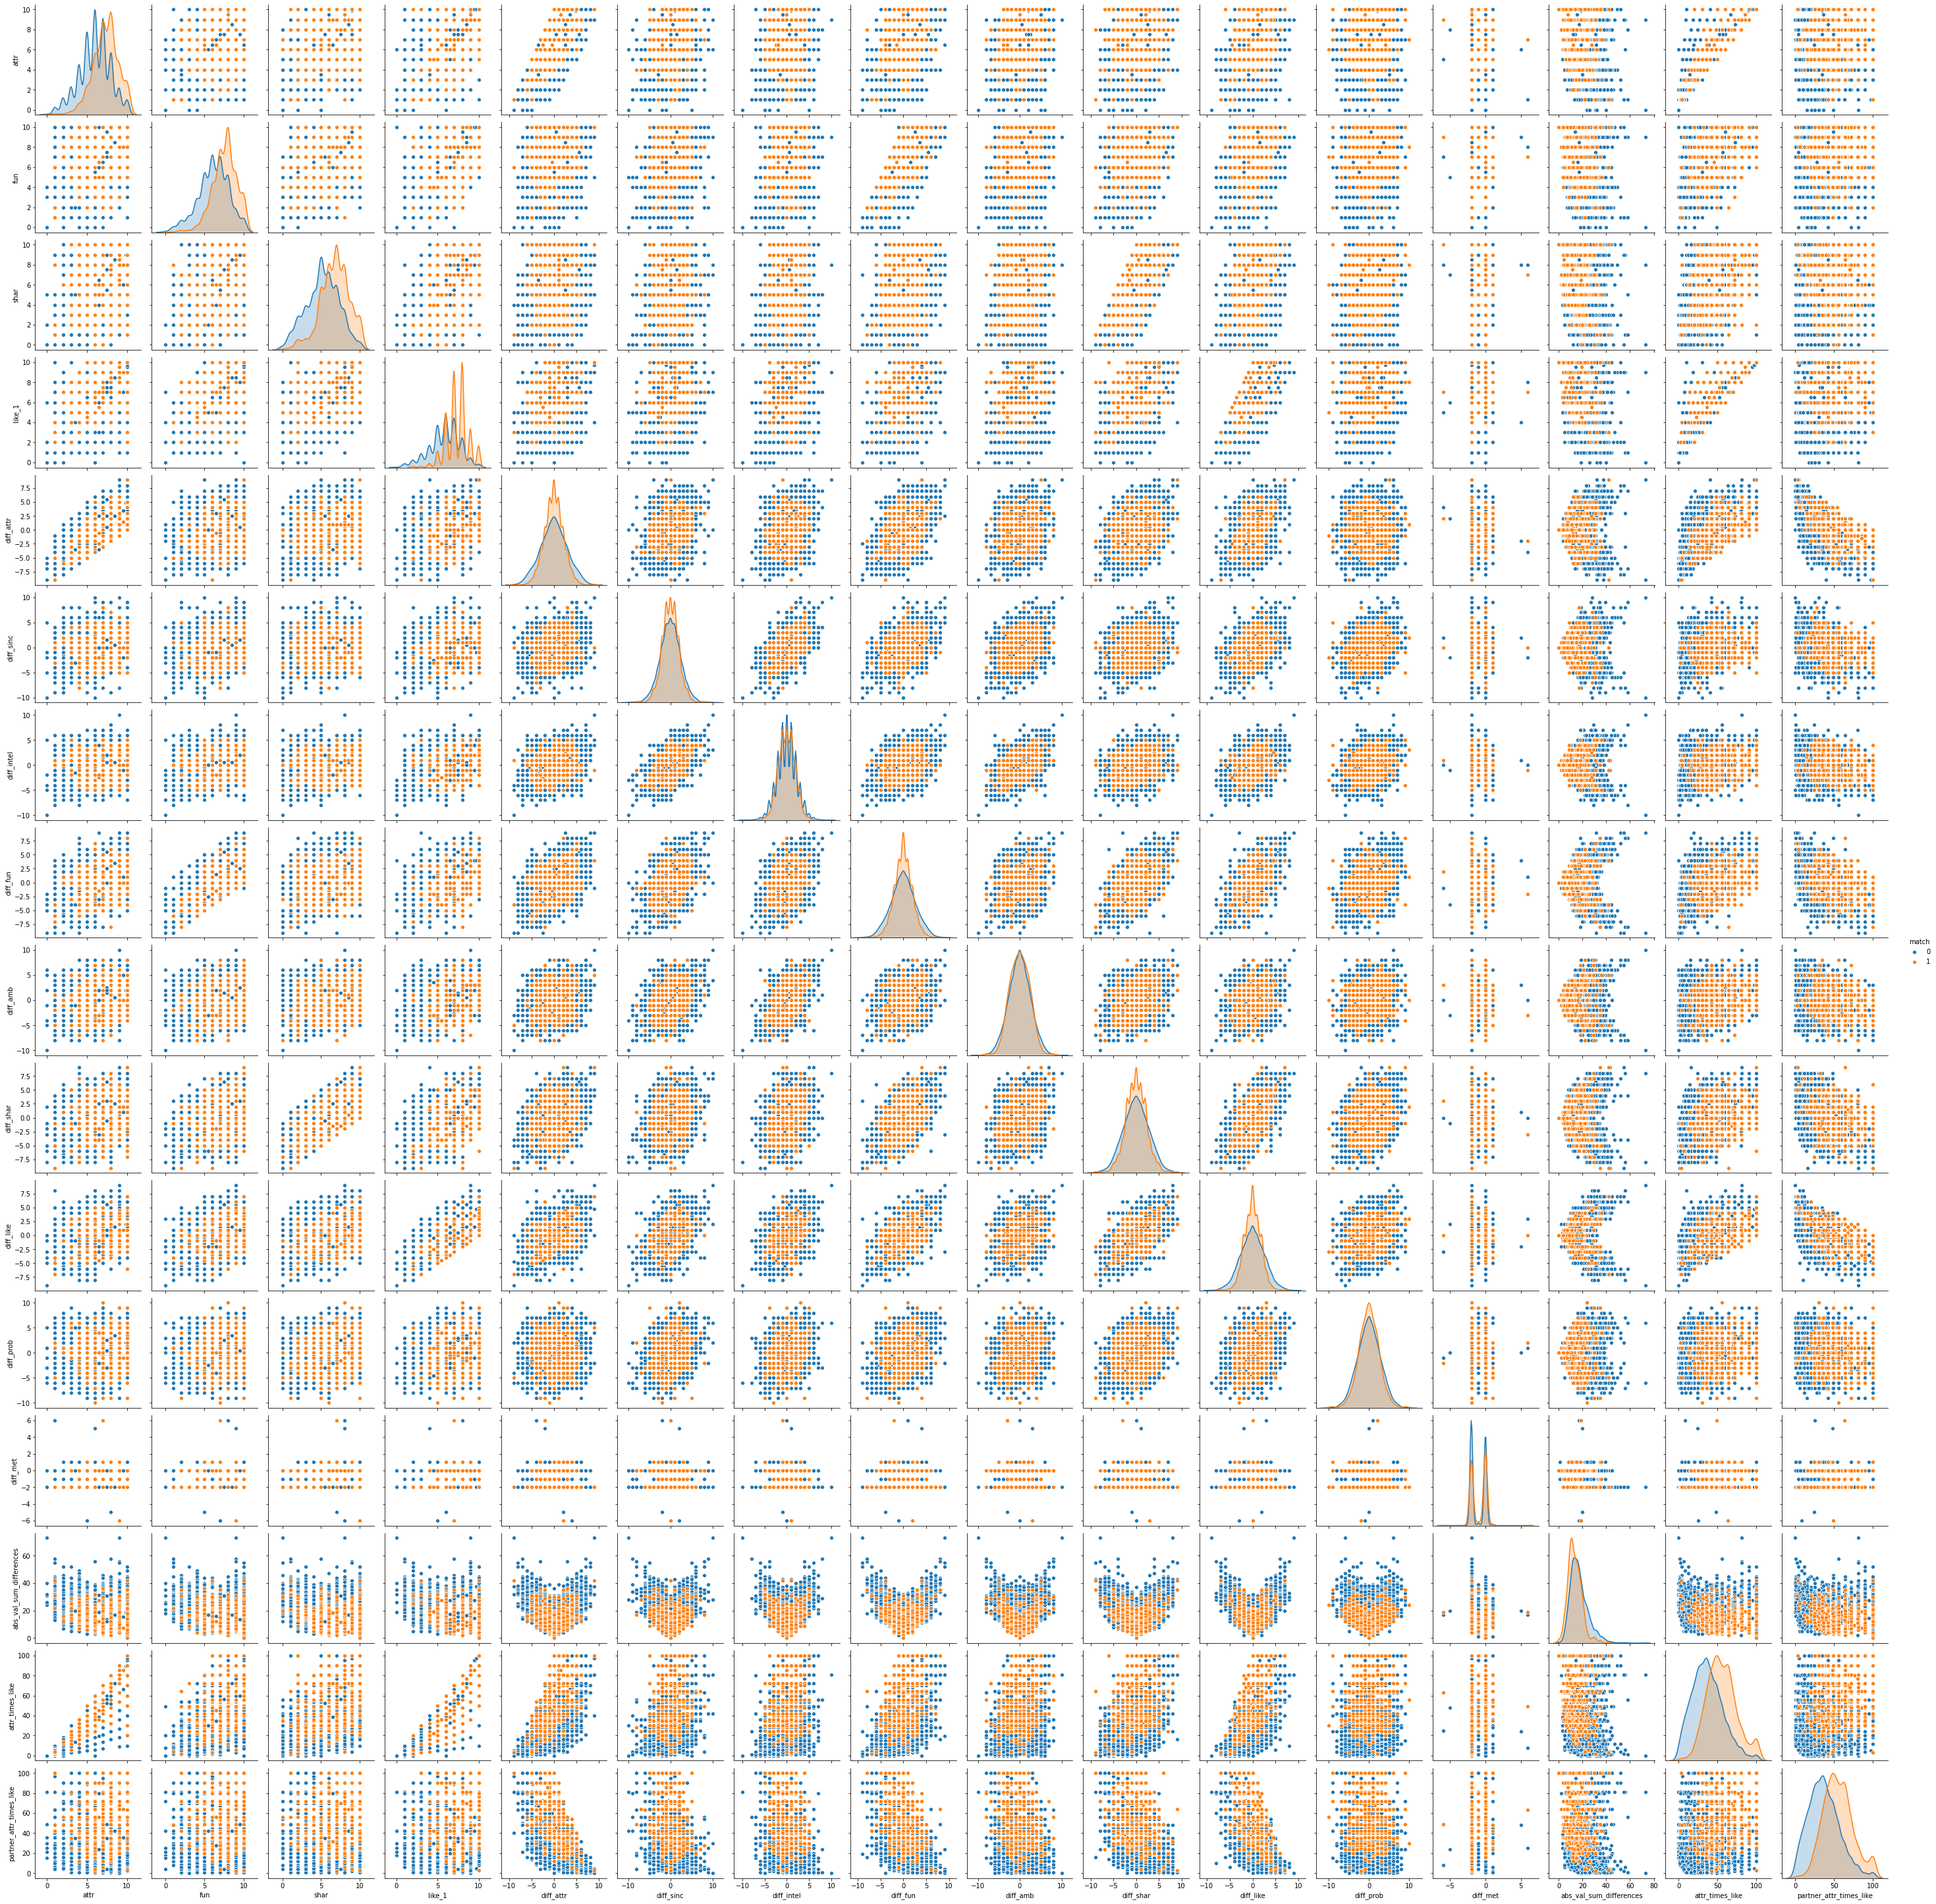

In [41]:
# Look at features by target
sns.pairplot(date_data, hue='match');

In [5]:
def separate_features_and_target(date_data):
    '''
    Returns 2 dataframes where features contains only the features for the
    model and target contains the targets.
    '''

    features_match, target_match = date_data.drop('match', axis=1), date_data['match']

    return features_match, target_match

In [6]:
def train_test_split_data(date_data):
    '''
    Return train and test dataframes.
    '''
    from sklearn.model_selection import train_test_split

    features_match, target_match = separate_features_and_target(date_data)

    X_train, X_test, y_train, y_test = train_test_split(features_match, target_match, test_size=.2)

    return X_train, X_test, y_train, y_test

In [7]:
# Separate train and test data
X_train_date_data, X_test_date_data, y_train_date_data, y_test_date_data = train_test_split_data(date_data)

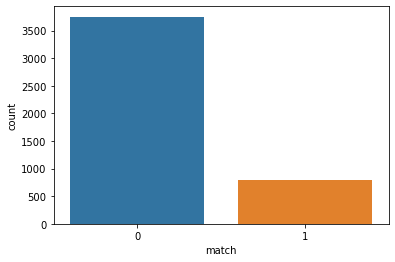

In [85]:
# Check for class imbalance (there is pretty significant imbalance)
df_train = X_train_date_data.copy()
df_train['match'] = y_train_date_data

sns.countplot(x='match', data=df_train);

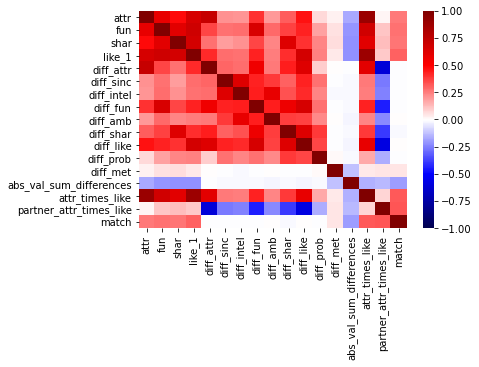

In [91]:
# Examine correlation of features
sns.heatmap(df_train.corr(), cmap='seismic', vmin=-1, vmax=1)

In [10]:
# Load in models
def knn_model_cv_with_ss(x_data, y_data, k):
    '''
    A function that models data on K-nearest neighbors using Stratified K-folds
    WITH StandardScaler.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.
    k : Number of neighbors

    Returns
    -------
    Prints the average accuracy score, precision score, recall score, F1, and
    ROC AUC score of the folds.

    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
    for train_ind, val_ind in skf.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]
        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.values)
        x_val_scaled = scaler.transform(x_val.values)
        knn = KNeighborsClassifier(n_neighbors=k)
        knn.fit(x_train_scaled, y_train)
        y_pred = knn.predict(x_val_scaled)
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val, knn.predict_proba(x_val_scaled)[:, 1]))

    print('KNN results:\n'
          f'Accuracy mean: {np.mean(accuracy_scores)},\n'
          f'Precision mean: {np.mean(precision_scores)},\n'
          f'Recall mean: {np.mean(recall_scores)},\n'
          f'F1 mean: {np.mean(f1_scores)},\n'
          f'ROC AUC: {np.mean(roc_auc_scores)}')

def svm_model_cv_with_ss(x_data, y_data, kernels='rbf'):
    '''
    A function that models data on SVM using Stratified K-folds WITH
    StandardScaler.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.
    kernels : Specifies the kernel type to be used in the algorithm.
    It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’
    or a callable. If none is given, ‘rbf’ will be used.

    Returns
    -------
    Prints the average accuracy score, precision score, recall score, and F1 score of the folds.

    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []

    for train_ind, val_ind in skf.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.values)
        x_val_scaled = scaler.transform(x_val.values)

        svm_model = svm.SVC(kernel=kernels)
        svm_model.fit(x_train_scaled, y_train)
        y_pred = svm_model.predict(x_val_scaled)

        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))

    print('SVM results:\n'
          f'Accuracy mean: {np.mean(accuracy_scores)},\n'
          f'Precision mean: {np.mean(precision_scores)},\n'
          f'Recall mean: {np.mean(recall_scores)},\n'
          f'F1 mean: {np.mean(f1_scores)}')

def random_forest_model_cv(x_data, y_data, number_estimators=100):
    '''
    A function that models data on Random Forest Classification using Stratified K-folds.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.
    number_estimators : Number of trees in forest, 100 if not specified

    Returns
    -------
    Prints the average accuracy score, precision score, recall score, F1, and
    ROC AUC score of the folds.

    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_ind, val_ind in skf.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        random_forest = RandomForestClassifier(n_estimators=number_estimators)
        random_forest.fit(x_train, y_train)
        y_pred = random_forest.predict(x_val)

        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val, random_forest.predict_proba(x_val)[:, 1]))

    print('Random Forest results:\n'
          f'Accuracy mean: {np.mean(accuracy_scores)},\n'
          f'Precision mean: {np.mean(precision_scores)},\n'
          f'Recall mean: {np.mean(recall_scores)},\n'
          f'F1 mean: {np.mean(f1_scores)},\n'
          f'ROC AUC: {np.mean(roc_auc_scores)}')
    
def log_reg_model_cv_with_ss(x_data, y_data, c_value=1000):
    '''
    A function that models data on Logisitc Regression using Stratified K-folds WITH
    StandardScaler.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.
    c_value : C parameter, default is 1000

    Returns
    -------
    Prints the average accuracy score, precision score, recall score, F1, and
    ROC AUC score of the folds.

    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_ind, val_ind in skf.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]

        scaler = StandardScaler()
        x_train_scaled = scaler.fit_transform(x_train.values)
        x_val_scaled = scaler.transform(x_val.values)

        log_reg = LogisticRegression(C=c_value)
        log_reg.fit(x_train_scaled, y_train)
        y_pred = log_reg.predict(x_val_scaled)

        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val, log_reg.predict_proba(x_val_scaled)[:, 1]))

    print('Logistic results:\n'
          f'Accuracy mean: {np.mean(accuracy_scores)},\n'
          f'Precision mean: {np.mean(precision_scores)},\n'
          f'Recall mean: {np.mean(recall_scores)},\n'
          f'F1 mean: {np.mean(f1_scores)},\n'
          f'ROC AUC: {np.mean(roc_auc_scores)}')
    
def decision_tree_model_cv(x_data, y_data, max_d=None):
    '''
    A function that models data on Decision Tree Classifier using Stratified K-folds.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.
    max_d : Maximum depth of tree, None if not specified

    Returns
    -------
    Prints the average accuracy score, precision score, recall score, F1, and
    ROC AUC score of the folds.

    '''
    skf = StratifiedKFold(n_splits=5, shuffle=True)

    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []

    for train_ind, val_ind in skf.split(x_data, y_data):
        x_train, y_train = x_data.iloc[train_ind], y_data.iloc[train_ind]
        x_val, y_val = x_data.iloc[val_ind], y_data.iloc[val_ind]
        decision_tree = DecisionTreeClassifier(max_depth=max_d)
        decision_tree.fit(x_train, y_train)
        y_pred = decision_tree.predict(x_val)

        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val, decision_tree.predict_proba(x_val)[:, 1]))

    print('Decision tree results:\n'
          f'Accuracy mean: {np.mean(accuracy_scores)},\n'
          f'Precision mean: {np.mean(precision_scores)},\n'
          f'Recall mean: {np.mean(recall_scores)},\n'
          f'F1 mean: {np.mean(f1_scores)},\n'
          f'ROC AUC: {np.mean(roc_auc_scores)}\n')

**Examine train data with stratified cross validation to find model to tune**

In [11]:
knn_model_cv_with_ss(X_train_date_data, y_train_date_data, 5)

KNN results:
Accuracy mean: 0.8443865383774753,
Precision mean: 0.5814463566347373,
Recall mean: 0.38354430379746834,
F1 mean: 0.46110317809145274,
ROC AUC: 0.7670330105400731


In [69]:
svm_model_cv_with_ss(X_train_date_data, y_train_date_data, kernels='rbf')

SVM results:
Accuracy mean: 0.8503390176260023,
Precision mean: 0.6827175845486431,
Recall mean: 0.2617189389663791,
F1 mean: 0.3778508465944738


In [74]:
svm_model_cv_with_ss(X_train_date_data, y_train_date_data, kernels='linear')

/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM results:
Accuracy mean: 0.8305045437104459,
Precision mean: 0.5156177156177156,
Recall mean: 0.04955252761428687,
F1 mean: 0.08917477942772803


In [70]:
random_forest_model_cv(X_train_date_data, y_train_date_data, number_estimators=100)

Random Forest results:
Accuracy mean: 0.8461544812981753,
Precision mean: 0.5986743383199079,
Recall mean: 0.3431750382971862,
F1 mean: 0.43478280986503604,
ROC AUC: 0.8363566502727835


In [71]:
log_reg_model_cv_with_ss(X_train_date_data, y_train_date_data, c_value=1000)

Logistic results:
Accuracy mean: 0.8488017815424816,
Precision mean: 0.6224143492129126,
Recall mean: 0.3291461743126663,
F1 mean: 0.42875856438013316,
ROC AUC: 0.8478506006611305


In [72]:
decision_tree_model_cv(X_train_date_data, y_train_date_data, max_d=None)

Decision tree results:
Accuracy mean: 0.786420595563629,
Precision mean: 0.3924491523569188,
Recall mean: 0.4193259695235024,
F1 mean: 0.4041690204466487,
ROC AUC: 0.6412328737670993



**Tune logistic and random forest models**

In [92]:
random_forest_model_cv(X_train_date_data, y_train_date_data, number_estimators=100)

Random Forest results:
Accuracy mean: 0.8485769030885575,
Precision mean: 0.612388657242829,
Recall mean: 0.34943158913166167,
F1 mean: 0.4442918802827663,
ROC AUC: 0.8380710097019538


In [93]:
random_forest_model_cv(X_train_date_data, y_train_date_data, number_estimators=10)

Random Forest results:
Accuracy mean: 0.8428539164306981,
Precision mean: 0.5869766891668322,
Recall mean: 0.3177618318148835,
F1 mean: 0.411197398444391,
ROC AUC: 0.80129918030584


In [94]:
random_forest_model_cv(X_train_date_data, y_train_date_data, number_estimators=50)

Random Forest results:
Accuracy mean: 0.849681867413995,
Precision mean: 0.621754744373792,
Recall mean: 0.3430944126421027,
F1 mean: 0.44146880775302566,
ROC AUC: 0.8319056357332902


In [95]:
random_forest_model_cv(X_train_date_data, y_train_date_data, number_estimators=150)

Random Forest results:
Accuracy mean: 0.849459660302396,
Precision mean: 0.6263706679620658,
Recall mean: 0.33536241231960007,
F1 mean: 0.43441459248201014,
ROC AUC: 0.8358668171678895


In [96]:
log_reg_model_cv_with_ss(X_train_date_data, y_train_date_data, c_value=1000)

Logistic results:
Accuracy mean: 0.8457090956777682,
Precision mean: 0.604707360012006,
Recall mean: 0.3162944448923647,
F1 mean: 0.41509145577390766,
ROC AUC: 0.8486743153538123


In [97]:
log_reg_model_cv_with_ss(X_train_date_data, y_train_date_data, c_value=1)

Logistic results:
Accuracy mean: 0.8490186459694302,
Precision mean: 0.6297056653202833,
Recall mean: 0.3175522051116665,
F1 mean: 0.4204682257290506,
ROC AUC: 0.8488683598054234


In [98]:
log_reg_model_cv_with_ss(X_train_date_data, y_train_date_data, c_value=10)

Logistic results:
Accuracy mean: 0.8474765528998635,
Precision mean: 0.6153507034071096,
Recall mean: 0.3227767475610739,
F1 mean: 0.4226561855239076,
ROC AUC: 0.8489763283076674


In [99]:
log_reg_model_cv_with_ss(X_train_date_data, y_train_date_data, c_value=100)

Logistic results:
Accuracy mean: 0.8483568816206791,
Precision mean: 0.6247492567673291,
Recall mean: 0.3201644763363702,
F1 mean: 0.42282593185479217,
ROC AUC: 0.8490032626515092


In [100]:
log_reg_model_cv_with_ss(X_train_date_data, y_train_date_data, c_value=10000)

Logistic results:
Accuracy mean: 0.8479165958356202,
Precision mean: 0.6186116015708178,
Recall mean: 0.3240586954769007,
F1 mean: 0.4240329683409274,
ROC AUC: 0.8481473621973178


**Move forward with logistic regression model**

In [108]:
# Try oversampling with class imbalance

def log_reg_with_oversampling(X, y, c_value=1000):
    '''
    A function that models data on Logisitc Regressio using cross-validation WITH
    StandardScaler AND oversampling.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.
    c_value : C parameter, default is 1000

    Returns
    -------
    Prints the average accuracy score, precision score, recall score, and F1
    score of the folds. 

    '''
    kf = StratifiedKFold(n_splits=5,shuffle=True)
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
        
    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)  
        X_val_scaled = scaler.transform(X_val.values)
        
        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos * 2, 0 : n_neg}

        # randomly oversample positive samples: create 4x as many 
        ROS = imblearn.over_sampling.RandomOverSampler(sampling_strategy = ratio, random_state=42) 
    
        X_tr_rs, y_tr_rs = ROS.fit_sample(X_train_scaled, y_train)
        
        log_reg = LogisticRegression(C=c_value)
        log_reg.fit(X_tr_rs, y_tr_rs)
        y_pred = log_reg.predict(X_val_scaled)
        
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:, 1]))
        
    print('Logistic results:\n'
          f'Accuracy mean: {np.mean(accuracy_scores)},\n'
          f'Precision mean: {np.mean(precision_scores)},\n'
          f'Recall mean: {np.mean(recall_scores)},\n'
          f'F1 mean: {np.mean(f1_scores)},\n'
          f'ROC AUC: {np.mean(roc_auc_scores)}')

In [109]:
log_reg_with_oversampling(X_train_date_data, y_train_date_data, c_value=100)

Logistic results:
Accuracy mean: 0.8362331159022579,
Precision mean: 0.5268157165613114,
Recall mean: 0.5565427719100218,
F1 mean: 0.5410688251899005,
ROC AUC: 0.8470856244456988


In [110]:
log_reg_with_oversampling(X_train_date_data, y_train_date_data, c_value=1000)

Logistic results:
Accuracy mean: 0.8338060799751321,
Precision mean: 0.5200683568912338,
Recall mean: 0.5463113762799323,
F1 mean: 0.5328057123952675,
ROC AUC: 0.8462985299255557


In [111]:
log_reg_with_oversampling(X_train_date_data, y_train_date_data, c_value=10)

Logistic results:
Accuracy mean: 0.8335904297946952,
Precision mean: 0.519063508437717,
Recall mean: 0.5527775538176247,
F1 mean: 0.5351727288043178,
ROC AUC: 0.8487958558413287


In [112]:
log_reg_with_oversampling(X_train_date_data, y_train_date_data, c_value=1)

Logistic results:
Accuracy mean: 0.8357945300623151,
Precision mean: 0.525911976015285,
Recall mean: 0.546400064500524,
F1 mean: 0.5358828084716802,
ROC AUC: 0.8468991104302722


In [114]:
# Try SMOTE with class imbalance
def log_reg_with_smote(X, y, c_value=1000):
    '''
    A function that models data on Logisitc Regressio using cross-validation WITH
    StandardScaler AND SMOTE.

    Parameters
    ----------
    X : Feature training and validation set.
    y : Target training and validation set.
    c_value : C parameter, default is 1000

    Returns
    -------
    Prints the average accuracy score, precision score, recall score, and F1
    score of the folds. 

    '''
    kf = StratifiedKFold(n_splits=5,shuffle=True)
    
    accuracy_scores = []
    precision_scores = []
    recall_scores = []
    f1_scores = []
    roc_auc_scores = []
        
    for train_ind, val_ind in kf.split(X, y):
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train.values)  
        X_val_scaled = scaler.transform(X_val.values)
        
        n_pos = np.sum(y_train == 1)
        n_neg = np.sum(y_train == 0)
        ratio = {1 : n_pos * 2, 0 : n_neg}

        # Apply with SMOTE
        smote = imblearn.over_sampling.SMOTE(sampling_strategy=ratio, random_state = 42)
    
        X_tr_rs, y_tr_rs = smote.fit_sample(X_train_scaled, y_train)
        
        log_reg = LogisticRegression(C=c_value)
        log_reg.fit(X_tr_rs, y_tr_rs)
        y_pred = log_reg.predict(X_val_scaled)
        
        accuracy_scores.append(accuracy_score(y_val, y_pred))
        precision_scores.append(precision_score(y_val, y_pred))
        recall_scores.append(recall_score(y_val, y_pred))
        f1_scores.append(f1_score(y_val, y_pred))
        roc_auc_scores.append(roc_auc_score(y_val, log_reg.predict_proba(X_val_scaled)[:, 1]))
        
    print('Logistic results:\n'
          f'Accuracy mean: {np.mean(accuracy_scores)},\n'
          f'Precision mean: {np.mean(precision_scores)},\n'
          f'Recall mean: {np.mean(recall_scores)},\n'
          f'F1 mean: {np.mean(f1_scores)},\n'
          f'ROC AUC: {np.mean(roc_auc_scores)}')

In [115]:
log_reg_with_smote(X_train_date_data, y_train_date_data, c_value=1)

Logistic results:
Accuracy mean: 0.8344746441043475,
Precision mean: 0.5221056180399951,
Recall mean: 0.5451503668467306,
F1 mean: 0.533320617282756,
ROC AUC: 0.8472461071246202


In [116]:
log_reg_with_smote(X_train_date_data, y_train_date_data, c_value=10)

Logistic results:
Accuracy mean: 0.8355800941283895,
Precision mean: 0.525642145739077,
Recall mean: 0.5578327823913569,
F1 mean: 0.5408550814685784,
ROC AUC: 0.8482932838829316


In [117]:
log_reg_with_smote(X_train_date_data, y_train_date_data, c_value=100)

Logistic results:
Accuracy mean: 0.8340314441276611,
Precision mean: 0.5203256084571349,
Recall mean: 0.5552124486011448,
F1 mean: 0.5369577919842798,
ROC AUC: 0.8466162272568465


In [118]:
log_reg_with_smote(X_train_date_data, y_train_date_data, c_value=1000)

Logistic results:
Accuracy mean: 0.8346941798736213,
Precision mean: 0.523261647541293,
Recall mean: 0.5565669596065469,
F1 mean: 0.5389830028526157,
ROC AUC: 0.8467713080168776


In [133]:
# Logistic Regression Grid Search
parameters = {'class_weight':('None', 'balanced'), 'C':[0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000, 1000000]}
log_reg = LogisticRegression()
clf = GridSearchCV(log_reg, parameters)
grid_result = clf.fit(X_train_date_data, y_train_date_data)
best_params = grid_result.best_params_

/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.

limit_output extension: Maximum message size of 10000 exceeded with 10393 characters

In [135]:
best_params

{'C': 1, 'class_weight': 'None'}

In [136]:
# Assess final model (train and test data)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_date_data.values)  
X_test_scaled = scaler.transform(X_test_date_data.values)
          
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train_date_data)
y_pred = log_reg.predict(X_test_scaled)
        
accuracy_score = accuracy_score(y_test_date_data, y_pred)
precision_score = precision_score(y_test_date_data, y_pred)
recall_score = recall_score(y_test_date_data, y_pred)
f1_score = f1_score(y_test_date_data, y_pred)
roc_auc_score = roc_auc_score(y_test_date_data, log_reg.predict_proba(X_test_scaled)[:,1])

In [138]:
# Final model metrics
accuracy_score

0.8361233480176211

In [139]:
# Final model metrics
precision_score

0.6146788990825688

In [140]:
# Final model metrics
recall_score

0.3175355450236967

In [141]:
# Final model metrics
f1_score

0.41875

In [137]:
# Final model metrics
roc_auc_score

0.8406628916107589

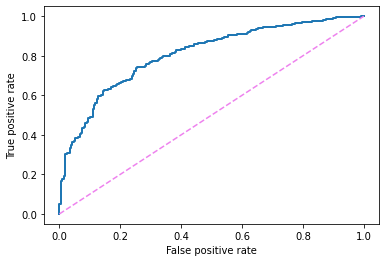

In [147]:
# Plot ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test_date_data, log_reg.predict_proba(X_test_date_data)[:,1], pos_label=0)

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

In [196]:
# Confusion matrix
confusion_matrix(y_test_date_data, y_pred)

array([[882,  42],
       [144,  67]])

In [197]:
# Feature importance
importance = log_reg.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 1.84438
Feature: 1, Score: 0.34666
Feature: 2, Score: 0.39086
Feature: 3, Score: 2.05132
Feature: 4, Score: -1.25214
Feature: 5, Score: 0.02339
Feature: 6, Score: -0.01469
Feature: 7, Score: -0.25379
Feature: 8, Score: 0.00964
Feature: 9, Score: -0.29423
Feature: 10, Score: -1.22942
Feature: 11, Score: -0.02867
Feature: 12, Score: -0.00094
Feature: 13, Score: -0.24135
Feature: 14, Score: -0.94238
Feature: 15, Score: -0.74860


## **Participant Data: Predicting a date after speed dating event**

In [149]:
participant_data.head()

date_after  participant  race_importance  religious_importance  \
0         0.0           14              1.0                   1.0   
1         1.0          524              9.0                   6.0   
2         0.0          128              3.0                   1.0   
3         1.0          242              3.0                   3.0   
4         1.0          448              1.0                   1.0   

   self_sincere  self_intelligent  reading  race_squared  confidence  \
0           9.0               9.0      6.0           1.0        27.0   
1           9.0               8.0      7.0          81.0        20.0   
2           7.0               8.0      5.0           9.0        23.0   
3           9.0               8.0     10.0           9.0        22.0   
4           9.0               9.0      7.0           1.0        25.0   

   sociableness  tv_oriented_activities  culture_activities  social_outings  \
0           5.0                    21.0                23.0            22.0   
1          11.0                    11.0                36.0            22.0   
2           5.0                    17.0                27.0            19.0   
3          10.0                    10.0                49.0            27.0   
4           3.0                    10.0                40.0            24.0   

   active_activities  
0               29.0  
1               22.0  
2               25.0  
3               28.0  
4               15.0

In [150]:
participant_data.shape

(261, 14)

In [151]:
participant_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 261 entries, 0 to 260
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date_after              261 non-null    float64
 1   participant             261 non-null    int64  
 2   race_importance         261 non-null    float64
 3   religious_importance    261 non-null    float64
 4   self_sincere            261 non-null    float64
 5   self_intelligent        261 non-null    float64
 6   reading                 261 non-null    float64
 7   race_squared            261 non-null    float64
 8   confidence              261 non-null    float64
 9   sociableness            261 non-null    float64
 10  tv_oriented_activities  261 non-null    float64
 11  culture_activities      261 non-null    float64
 12  social_outings          261 non-null    float64
 13  active_activities       261 non-null    float64
dtypes: float64(13), int64(1)
memory usage: 28.

In [152]:
participant_data.describe()

date_after  participant  race_importance  religious_importance  \
count  261.000000   261.000000       261.000000            261.000000   
mean     0.356322   248.915709         3.931034              3.835249   
std      0.479832   152.858483         2.952677              2.845993   
min      0.000000     1.000000         1.000000              1.000000   
25%      0.000000   122.000000         1.000000              1.000000   
50%      0.000000   232.000000         3.000000              3.000000   
75%      1.000000   369.000000         6.000000              6.000000   
max      1.000000   552.000000        10.000000             10.000000   

       self_sincere  self_intelligent     reading  race_squared  confidence  \
count    261.000000         261.00000  261.000000    261.000000  261.000000   
mean       8.306513           8.35249    7.785441     24.137931   22.954023   
std        1.402579           1.13268    2.028627     29.465693    3.164374   
min        3.000000           3.00000    1.000000      1.000000   11.000000   
25%        8.000000           8.00000    7.000000      1.000000   21.000000   
50%        8.000000           8.00000    8.000000      9.000000   23.000000   
75%        9.000000           9.00000    9.000000     36.000000   25.000000   
max       10.000000          10.00000   13.000000    100.000000   30.000000   

       sociableness  tv_oriented_activities  culture_activities  \
count    261.000000              261.000000          261.000000   
mean       7.118774               13.536398           36.268199   
std        2.202549                5.290377            7.286243   
min        2.000000                3.000000           12.000000   
25%        5.000000               10.000000           32.000000   
50%        7.000000               13.000000           37.000000   
75%        9.000000               18.000000           42.000000   
max       14.000000               34.000000           50.000000   

       social_outings  active_activities  
count      261.000000         261.000000  
mean        20.118774          22.854406  
std          4.321377           6.291773  
min          6.000000           4.000000  
25%         17.000000          19.000000  
50%         20.000000          23.000000  
75%         23.000000          27.000000  
max         29.000000          40.000000

In [153]:
participant_data.groupby('date_after').mean()

participant  race_importance  religious_importance  self_sincere  \
date_after                                                                     
0.0          238.601190         4.327381              4.053571      8.255952   
1.0          267.548387         3.215054              3.440860      8.397849   

            self_intelligent   reading  race_squared  confidence  \
date_after                                                         
0.0                 8.315476  7.702381     27.791667   22.875000   
1.0                 8.419355  7.935484     17.537634   23.096774   

            sociableness  tv_oriented_activities  culture_activities  \
date_after                                                             
0.0             7.244048               14.160714           36.458333   
1.0             6.892473               12.408602           35.924731   

            social_outings  active_activities  
date_after                                     
0.0              20.160714          22.392857  
1.0              20.043011          23.688172

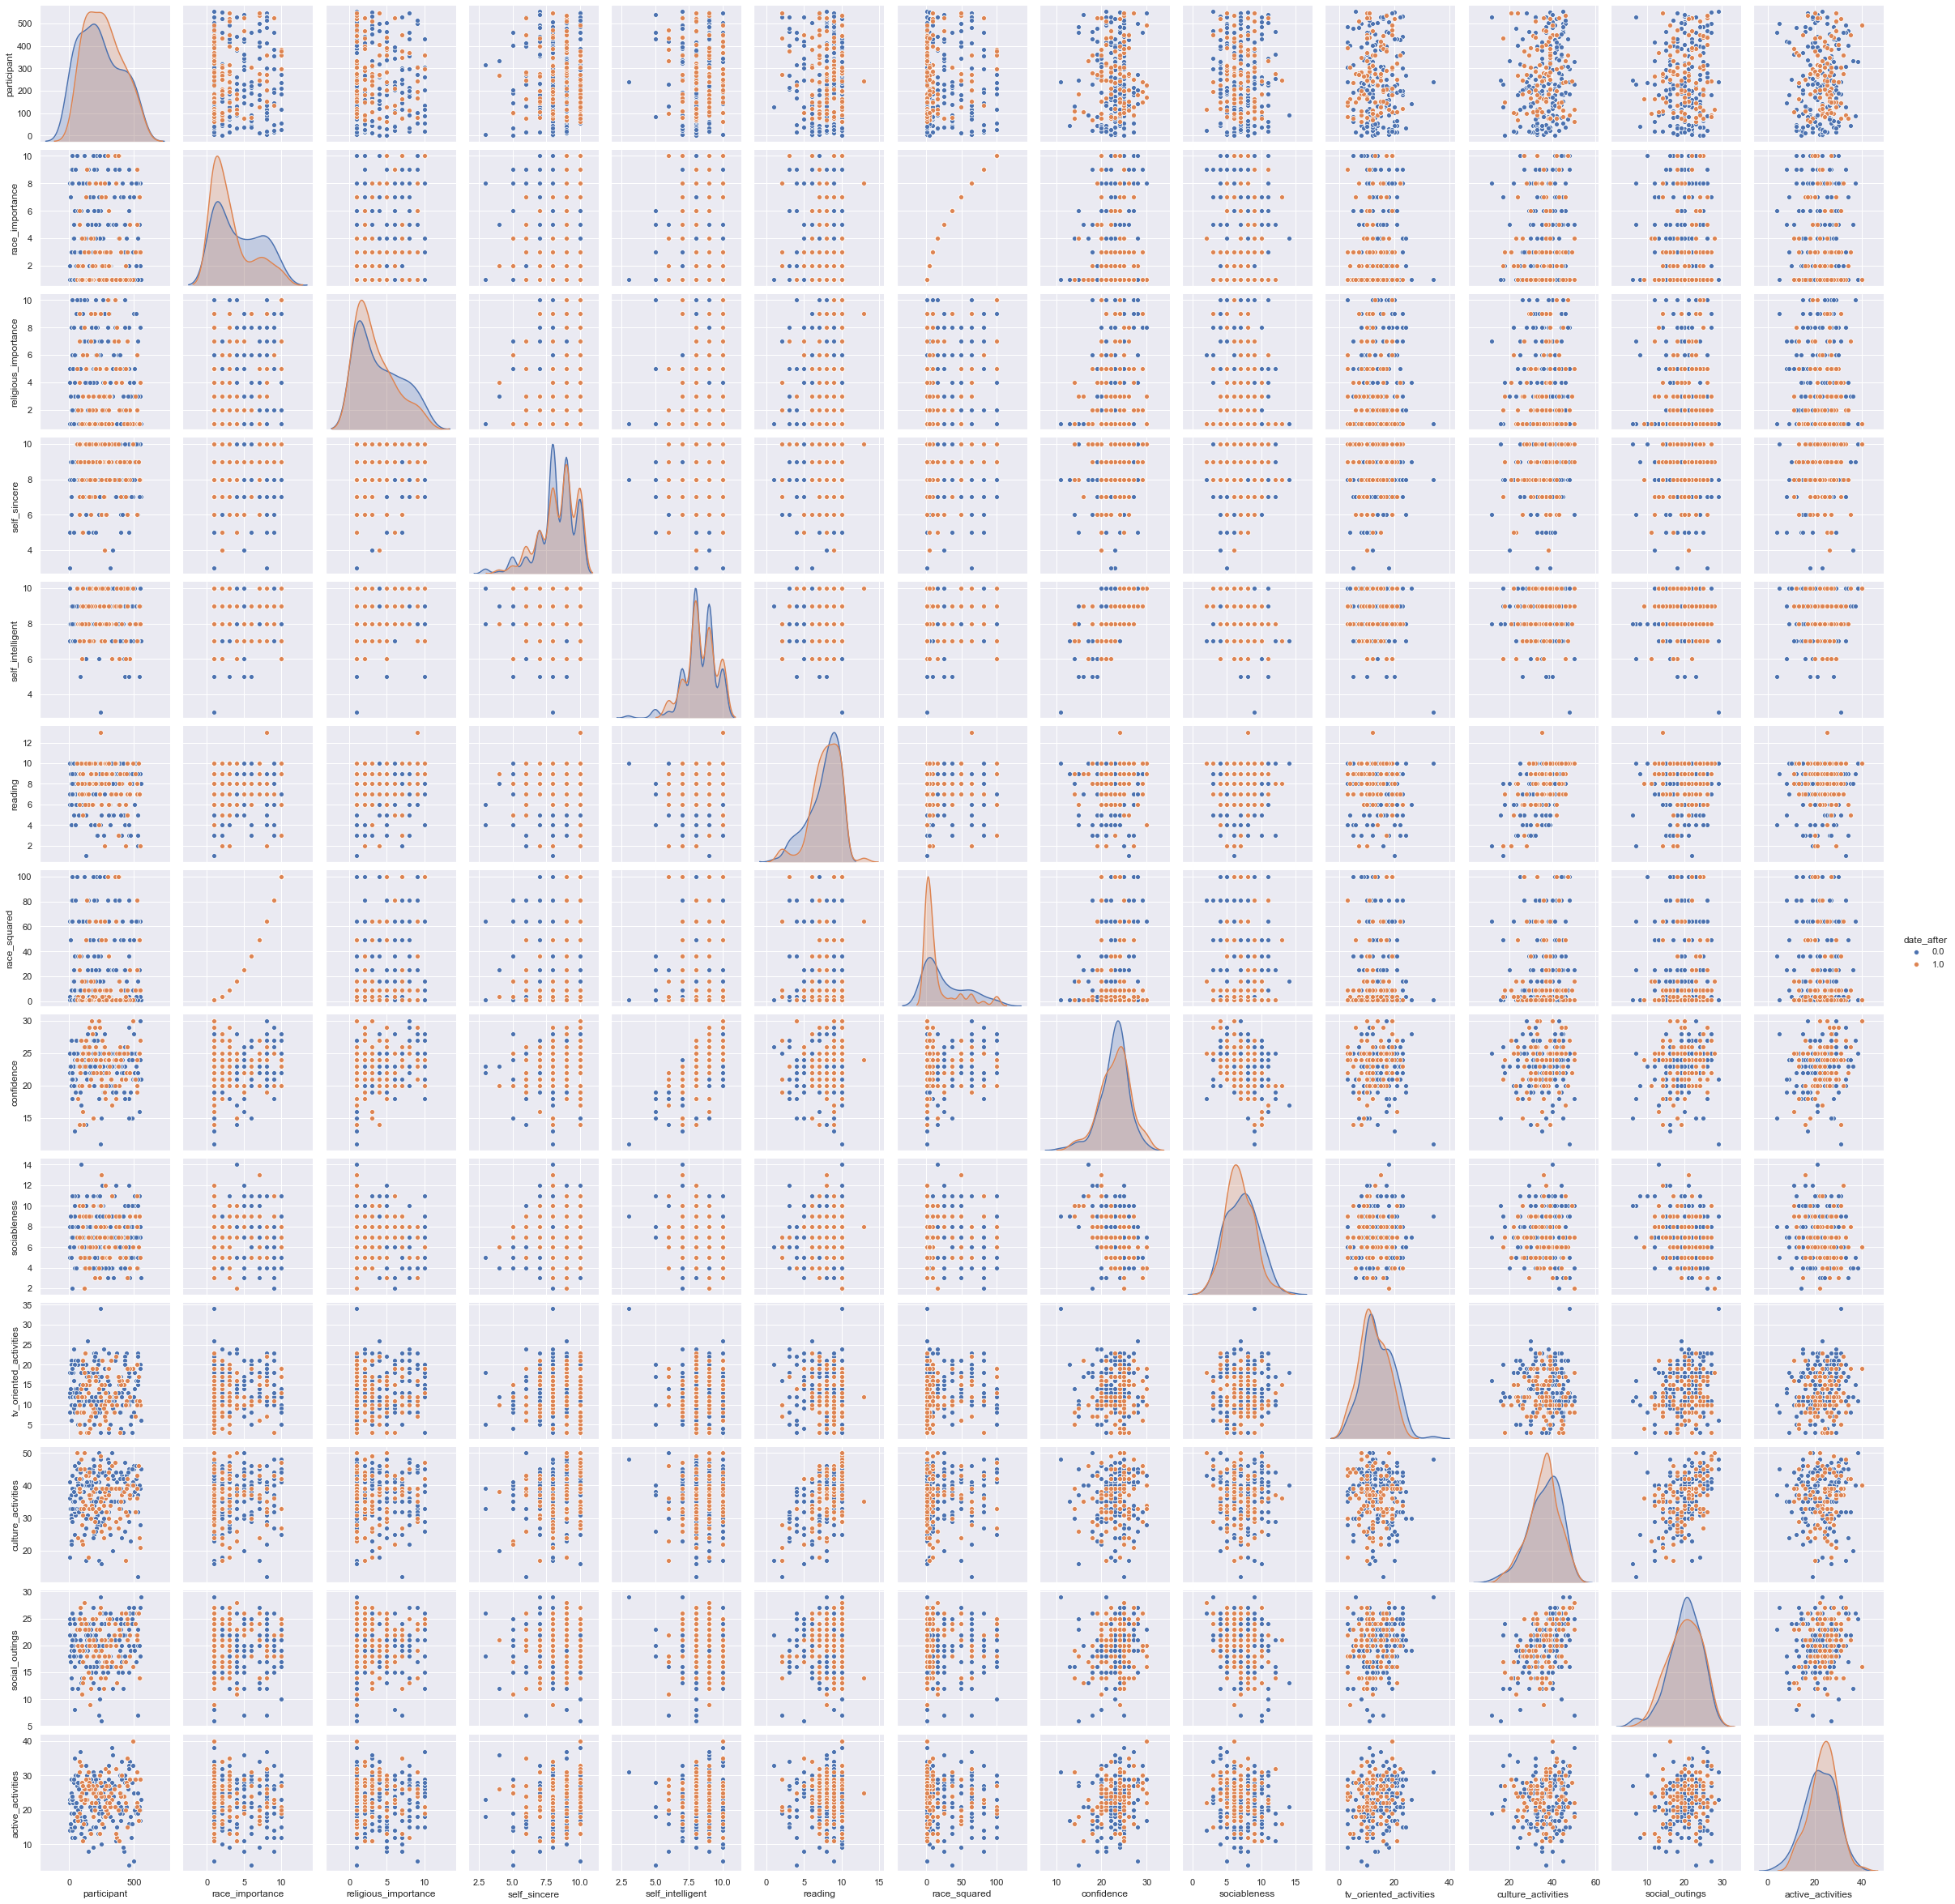

In [154]:
# Look at features by target
sns.pairplot(participant_data, hue='date_after');

In [156]:
def separate_features_and_target_participants(participant_data):
    '''
    Returns 2 dataframes where features contains only the features for the
    model and target contains the targets for the participant data.
    '''

    features_match, target_match = participant_data.drop('date_after', axis=1), participant_data['date_after']

    return features_match, target_match

In [157]:
def train_test_split_data(participant_data):
    '''
    Return train and test dataframes.
    '''

    features_match, target_match = separate_features_and_target_participants(participant_data)

    X_train, X_test, y_train, y_test = train_test_split(features_match, target_match, test_size=.2)

    return X_train, X_test, y_train, y_test

In [158]:
# Separate train and test data
X_train_participant_data, X_test_participant_data, y_train_participant_data, y_test_dparticipant_data = train_test_split_data(participant_data)

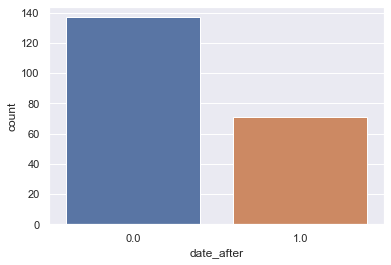

In [159]:
# Check for class imbalance (there is pretty significant imbalance)
df_train = X_train_participant_data.copy()
df_train['date_after'] = y_train_participant_data

sns.countplot(x='date_after', data=df_train);

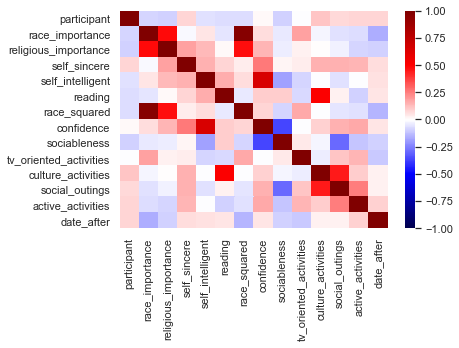

In [160]:
# Examine correlation of features
sns.heatmap(df_train.corr(), cmap='seismic', vmin=-1, vmax=1)

**Examine train data with stratified cross validation to find model to tune**

In [161]:
knn_model_cv_with_ss(X_train_participant_data, y_train_participant_data, 5)

KNN results:
Accuracy mean: 0.6394889663182346,
Precision mean: 0.4728321678321678,
Recall mean: 0.3533333333333334,
F1 mean: 0.40129085729085723,
ROC AUC: 0.5810827664399093


In [162]:
svm_model_cv_with_ss(X_train_participant_data, y_train_participant_data, kernels='rbf')

SVM results:
Accuracy mean: 0.6347270615563299,
Precision mean: 0.31666666666666665,
Recall mean: 0.04285714285714286,
F1 mean: 0.07241830065359478


/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [163]:
svm_model_cv_with_ss(X_train_participant_data, y_train_participant_data, kernels='linear')

SVM results:
Accuracy mean: 0.6586527293844368,
Precision mean: 0.0,
Recall mean: 0.0,
F1 mean: 0.0


/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/lisavandervo

In [164]:
random_forest_model_cv(X_train_participant_data, y_train_participant_data, number_estimators=100)

Random Forest results:
Accuracy mean: 0.6396051103368177,
Precision mean: 0.36611111111111116,
Recall mean: 0.19619047619047617,
F1 mean: 0.25317245683378403,
ROC AUC: 0.5540375409423028


In [165]:
log_reg_model_cv_with_ss(X_train_participant_data, y_train_participant_data, c_value=1000)

Logistic results:
Accuracy mean: 0.6053426248548199,
Precision mean: 0.4412121212121212,
Recall mean: 0.15523809523809523,
F1 mean: 0.2004812030075188,
ROC AUC: 0.5233257747543462


In [166]:
decision_tree_model_cv(X_train_participant_data, y_train_participant_data, max_d=None)

Decision tree results:
Accuracy mean: 0.5671312427409989,
Precision mean: 0.3736056049213944,
Recall mean: 0.3952380952380952,
F1 mean: 0.3823900318748189,
ROC AUC: 0.5256613756613756



**Tune KNN and random forest models**

In [167]:
random_forest_model_cv(X_train_participant_data, y_train_participant_data, number_estimators=1)

Random Forest results:
Accuracy mean: 0.5684088269454124,
Precision mean: 0.3547008547008547,
Recall mean: 0.35428571428571426,
F1 mean: 0.34978562306148514,
ROC AUC: 0.516957671957672


In [168]:
random_forest_model_cv(X_train_participant_data, y_train_participant_data, number_estimators=10)

Random Forest results:
Accuracy mean: 0.6681765389082462,
Precision mean: 0.5031746031746032,
Recall mean: 0.27999999999999997,
F1 mean: 0.35261843867981973,
ROC AUC: 0.6166452506928697


In [169]:
random_forest_model_cv(X_train_participant_data, y_train_participant_data, number_estimators=25)

Random Forest results:
Accuracy mean: 0.5770034843205576,
Precision mean: 0.2935231435231435,
Recall mean: 0.1657142857142857,
F1 mean: 0.2064875864875865,
ROC AUC: 0.5232999496094735


In [170]:
random_forest_model_cv(X_train_participant_data, y_train_participant_data, number_estimators=50)

Random Forest results:
Accuracy mean: 0.6878048780487805,
Precision mean: 0.6057142857142856,
Recall mean: 0.2542857142857143,
F1 mean: 0.3543145743145743,
ROC AUC: 0.5904491055681531


In [171]:
random_forest_model_cv(X_train_participant_data, y_train_participant_data, number_estimators=75)

Random Forest results:
Accuracy mean: 0.6536585365853658,
Precision mean: 0.4904761904761905,
Recall mean: 0.19809523809523805,
F1 mean: 0.28080808080808084,
ROC AUC: 0.5859416729654825


In [172]:
random_forest_model_cv(X_train_participant_data, y_train_participant_data, number_estimators=100)

Random Forest results:
Accuracy mean: 0.5962833914053427,
Precision mean: 0.3516666666666667,
Recall mean: 0.18285714285714283,
F1 mean: 0.23515590689503738,
ROC AUC: 0.5235550516502897


In [173]:
knn_model_cv_with_ss(X_train_participant_data, y_train_participant_data, 3)

KNN results:
Accuracy mean: 0.5434378629500581,
Precision mean: 0.3035103785103785,
Recall mean: 0.2533333333333333,
F1 mean: 0.27190788444161756,
ROC AUC: 0.5011495338876292


In [174]:
knn_model_cv_with_ss(X_train_participant_data, y_train_participant_data, 5)

KNN results:
Accuracy mean: 0.6006968641114983,
Precision mean: 0.39941724941724943,
Recall mean: 0.29523809523809524,
F1 mean: 0.33708088690697385,
ROC AUC: 0.567317334341144


In [175]:
knn_model_cv_with_ss(X_train_participant_data, y_train_participant_data, 7)

KNN results:
Accuracy mean: 0.5766550522648084,
Precision mean: 0.3169047619047619,
Recall mean: 0.23809523809523805,
F1 mean: 0.26844636844636843,
ROC AUC: 0.5139846308893927


In [176]:
knn_model_cv_with_ss(X_train_participant_data, y_train_participant_data, 10)

KNN results:
Accuracy mean: 0.634959349593496,
Precision mean: 0.39999999999999997,
Recall mean: 0.12571428571428572,
F1 mean: 0.18594771241830066,
ROC AUC: 0.5596069538926681


In [177]:
knn_model_cv_with_ss(X_train_participant_data, y_train_participant_data, 15)

KNN results:
Accuracy mean: 0.6543554006968642,
Precision mean: 0.5243956043956044,
Recall mean: 0.24095238095238095,
F1 mean: 0.3208131439710387,
ROC AUC: 0.5620975056689342


In [178]:
knn_model_cv_with_ss(X_train_participant_data, y_train_participant_data, 20)

KNN results:
Accuracy mean: 0.6392566782810686,
Precision mean: 0.4371428571428571,
Recall mean: 0.11238095238095239,
F1 mean: 0.17317435746228313,
ROC AUC: 0.5920647518266566


**Move forward with random forest model**

In [191]:
# Random Forest Grid Search
parameters = {'class_weight':('None', 'balanced'), 'n_estimators':[10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features':('auto', 'sqrt', 'log2')}
random_forest = RandomForestClassifier()
clf = GridSearchCV(random_forest, parameters)
grid_result = clf.fit(X_train_participant_data, y_train_participant_data)
best_params = grid_result.best_params_

/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 330, in fit
    y, expanded_class_weight = self._validate_y_class_weight(y)
  File "/Users/lisavandervoort/opt/anaconda3/envs/metis/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 581, in _validate_y_class_weight
    raise ValueError('Valid presets for class_weight include '
ValueError: Valid presets for class_weight include "balanced" and "balanced_subsample".Given "None".



limit_output extension: Maximum message size of 10000 exceeded with 64140 characters

In [192]:
best_params

{'class_weight': 'balanced', 'max_features': 'sqrt', 'n_estimators': 90}

In [215]:
# Assess final model (train and test data)
rf = RandomForestClassifier(n_estimators=90, max_features = 'sqrt', class_weight='balanced')
rf.fit(X_train_participant_data, y_train_participant_data)
y_pred = rf.predict(X_test_participant_data)
        
accuracy_score = accuracy_score(y_test_dparticipant_data, y_pred)
precision_score = precision_score(y_test_dparticipant_data, y_pred)
recall_score = recall_score(y_test_dparticipant_data, y_pred)
f1_score = f1_score(y_test_dparticipant_data, y_pred)
roc_auc_score = roc_auc_score(y_test_dparticipant_data, rf.predict_proba(X_test_participant_data)[:,1])

In [216]:
# Final model metrics
accuracy_score

0.7358490566037735

In [217]:
# Final model metrics
precision_score

1.0

In [218]:
# Final model metrics
recall_score

0.36363636363636365

In [219]:
# Final model metrics
f1_score

0.5333333333333333

In [220]:
# Final model metrics
roc_auc_score

0.7939882697947214

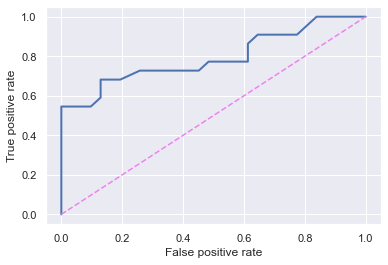

In [225]:
# Plot ROC AUC curve
fpr, tpr, thresholds = roc_curve(y_test_dparticipant_data, rf.predict_proba(X_test_participant_data)[:,1])

plt.plot(fpr, tpr,lw=2)
plt.plot([0,1],[0,1],c='violet',ls='--')
plt.xlim([-0.05,1.05])
plt.ylim([-0.05,1.05])


plt.xlabel('False positive rate')
plt.ylabel('True positive rate');

In [226]:
# Confusion matrix
confusion_matrix(y_test_dparticipant_data, y_pred)

array([[31,  0],
       [14,  8]])

In [228]:
importance = rf.feature_importances_

for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.16028
Feature: 1, Score: 0.05496
Feature: 2, Score: 0.06080
Feature: 3, Score: 0.05409
Feature: 4, Score: 0.03956
Feature: 5, Score: 0.05679
Feature: 6, Score: 0.04857
Feature: 7, Score: 0.08273
Feature: 8, Score: 0.08533
Feature: 9, Score: 0.10130
Feature: 10, Score: 0.09489
Feature: 11, Score: 0.07457
Feature: 12, Score: 0.08613
